In [1]:
import os

# Change to the parent directory
os.chdir('../..')

# Verify the path using getcwd()
cwd = os.getcwd()
print("Current working directory:", cwd)

Current working directory: c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1


In [2]:
# import torch
# torch.cuda.is_available()

In [3]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(f"Using {device} device")

# Building a NARX Neural Network

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from src.file_loader import load_csv_files
# import matplotlib as mpl
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense

In [5]:
# Verify the path using getcwd()
cwd = os.getcwd()
print("Current working directory:", cwd)

Current working directory: c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1


In [6]:
# List of file names
file_names = [
    '9171_20241001_N11507060127_ Rapid polarization-2.csv'
    ]

# print(f"Processing file: {file_names}")
dataframes = load_csv_files(file_names, '', 'deep learning assignment')


In [7]:
# Extract the DataFrame
data = dataframes['9171_20241001_N11507060127__Rapid_polarization-2_csv']

# Confirm it's a DataFrame
print(type(data))  # Should output <class 'pandas.core.frame.DataFrame'>

# Use the describe() method
print(data.describe())


<class 'pandas.core.frame.DataFrame'>
       Time (HH:mm:ss.SSS) Channel     CH      V      A
count                16383   16341  16320  16320  16320
unique               16323   16321      2    142     16
top                   Step     CH1    CH1  2.926  2.251
freq                    21      21  16299   2120   5620


In [8]:
data.head()

,Time (HH:mm:ss.SSS),Channel,CH,V,A
0,11:45:54.513,0.780562,CH1,1.429,0.046
1,11:45:54.753,1.0206133,CH1,1.444,0.046
2,11:45:54.983,1.2505946,CH1,1.452,0.046
3,11:45:55.223,1.490689,CH1,1.457,0.046
4,11:45:55.453,1.7206743,CH1,1.461,0.046


In [9]:
data.dtypes

Time (HH:mm:ss.SSS)    object
Channel                object
CH                     object
V                      object
A                      object
dtype: object

In [10]:
# Convert `V` and `A` columns to numeric
data['V'] = pd.to_numeric(data['V'], errors='coerce')
data['A'] = pd.to_numeric(data['A'], errors='coerce')

In [11]:
# Drop rows with NaN values in these columns if conversion fails
data = data.dropna(subset=['V', 'A'])

In [12]:
# Select numeric columns
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
numeric_data = data[numeric_cols]

# Apply MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(numeric_data)

# Create a new DataFrame with scaled values
scaled_data = pd.DataFrame(scaled, columns=numeric_cols, index=data.index)

# # Optional: Combine with non-numeric columns
# non_numeric_cols = data.select_dtypes(exclude=['float64', 'int64'])
# final_data = pd.concat([non_numeric_cols, scaled_data], axis=1)

# # Check the result
# print(final_data.head())

scaled_data.head()


,V,A
0,0.000000,0.0
1,0.007637,0.0
2,0.011711,0.0
3,0.014257,0.0
4,0.016293,0.0


## **NARX Neural Network Model**

The NARX (Nonlinear Autoregressive with Exogenous Inputs) model is a type of recurrent neural network (RNN) designed to predict future values in a time-series dataset by using past values of the target variable (autoregressive terms) and past values of external (exogenous) variables. It is particularly useful when the relationship between the variables is nonlinear, which is common in real-world systems

---

The NARX model leverages both historical values of the target variable and additional exogenous inputs to make predictions. This dual input system makes it highly effective for modeling time-series data where both internal system dynamics and external influences are important.

Mathematically, the NARX model is expressed as:

\[
y(t) = f(y(t-1), y(t-2), ..., y(t-n), u(t-1), u(t-2), ..., u(t-m)) + e(t)
\]

Where:
- \(y(t)\): The target variable at time \(t\).
- \(y(t-1), y(t-2), ..., y(t-n)\): The autoregressive terms — previous values of the target variable, up to time 𝑡−𝑛.
- \(u(t-1), u(t-2), ..., u(t-m)\): The exogenous input terms — previous values of the independent or external variables, up to time t−m.
- \(e(t)\): The error term at time \(t\).
- \(f\): A nonlinear function, typically approximated using a neural network.

In this framework:
- **\(y\)**: Represents the target variable.
- **\(u\)**: The input sequence of past data that influence the target variable.
- **Neural Network**: The function 𝑓 is modeled using a neural network, which learns the nonlinear relationships between the autoregressive terms, exogenous inputs, and the target variable. This is what makes NARX different from traditional linear autoregressive models.
---


In [13]:
# Alternative
def create_narx_sequences(data, target_column, input_lags=3, output_lags=2):
    """
    Generate sequences for a NARX model based on given input and output lags.

    Parameters:
    ----------
    data : ndarray
        Time-series data where each row is a time step and each column is a feature.
    target_column : int
        Index of the target (output) variable in the data.
    input_lags : int
        Number of past input time steps to include (n_b in the diagram).
    output_lags : int
        Number of past output time steps to include (n_a in the diagram).

    Returns:
    -------
    np.ndarray, np.ndarray
        Inputs and target sequences for training the NARX model.
    """
    inputs, targets = [], []
    n_samples = len(data)

    for t in range(max(input_lags, output_lags), n_samples):
        # Autoregressive terms: past outputs
        ar_terms = data[t - output_lags:t, target_column]

        # Exogenous terms: past inputs (all columns except target)
        exog_terms = data[t - input_lags:t, :].flatten()

        # Combine AR and exogenous terms
        input_vector = np.hstack([ar_terms, exog_terms])
        inputs.append(input_vector)

        # Target: current output
        targets.append(data[t, target_column])

    return np.array(inputs), np.array(targets)


In [14]:
# Define target (e.g., 'V' column as the target variable)
target_column = 0  # 'V' is the first column
input_lags = 3  # Number of past steps to include
output_lags = 2  # Predict one step ahead

x, y = create_narx_sequences(scaled_data.to_numpy(), target_column, input_lags, output_lags)
x.shape, y.shape

((16296, 8), (16296,))

In [15]:
# Train-test split
split_ratio = 0.25
split = int(len(x) * (1 - split_ratio))  # Calculate training set size
x_train, x_valid = x[:split], x[split:]  # Training set is from start to `split`, validation set is from `split` to end
y_train, y_valid = y[:split], y[split:]


print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_valid shape: {x_valid.shape}, y_valid shape: {y_valid.shape}")

x_train shape: (12222, 8), y_train shape: (12222,)
x_valid shape: (4074, 8), y_valid shape: (4074,)


### 1. Using Feedforward neural network (FNN) Implementation


## **NARXFFN (Nonlinear Autoregressive with Exogenous Inputs Feedforward Neural Network)**

The **NARXFFN** model is a simple feedforward neural network designed to predict future values based on past observations of both the target and exogenous variables. This model structure includes two layers:

### **Model Architecture**

```python
narxffn_model = keras.Sequential([
    layers.Dense(10, activation='tanh', input_shape=(x.shape[1],)),
    layers.Dense(1, activation='relu')
])
```

- **Input Layer**:
    - The input layer accepts a vector of size `x.shape[1]`, where `x.shape[1]` represents the number of input features (time steps or external variables).
    - The activation function used here is **'tanh'**, which helps capture nonlinear relationships in the data. The **tanh** function maps input values to a range of [-1, 1], allowing for better generalization in some cases.

- **Hidden Layer**:
    - A **Dense** layer with **10** units, using **'tanh'** as the activation function.
    - This layer learns to transform the input features in a nonlinear manner and captures the dependencies between the input features.

- **Output Layer**:
    - A **Dense** layer with a single output, which predicts the target value at time \(t\). The **'relu'** activation function is used here, which is commonly applied for regression tasks, as it ensures that the output is non-negative and handles large output values better.

### **Model Compilation**

```python
narxffn_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='mse',
    metrics=['mae']
)
```

- **Optimizer**: The **Adam** optimizer is used for training, which adjusts the model's weights based on the loss and gradients. It is efficient and widely used in training deep learning models.
- **Loss Function**: **Mean Squared Error (MSE)** is used as the loss function, which is typical for regression tasks. It penalizes large prediction errors more than smaller ones.
- **Metrics**: The model uses **Mean Absolute Error (MAE)** as an additional evaluation metric. This helps to understand the average magnitude of the errors, providing more interpretability of the model's performance in regression tasks.

---

In [ ]:
# Assuming x.shape[1] is the number of input features
narxffn_model = keras.Sequential([
    layers.Dense(10, activation='tanh', input_shape=(x.shape[1],)),
    layers.Dense(1, activation='relu')
])
00
# Corrected: Wrap the metrics argument in a list
narxffn_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='mse',
    metrics=['mae']
)

c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1\env_analysis\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
# Adding an EarlyStopping callback
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=100)

In [18]:
history = narxffn_model.fit(
    x,y, 
    epochs=500, 
    validation_split=0.2, 
    verbose=1, 
    callbacks=[callback]
    )

Epoch 1/500
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0034 - mae: 0.0367 - val_loss: 4.0237e-04 - val_mae: 0.0089
Epoch 2/500
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.8177e-04 - mae: 0.0072 - val_loss: 2.8044e-04 - val_mae: 0.0058
Epoch 3/500
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.9119e-04 - mae: 0.0047 - val_loss: 2.3882e-04 - val_mae: 0.0048
Epoch 4/500
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6112e-04 - mae: 0.0040 - val_loss: 2.2314e-04 - val_mae: 0.0047
Epoch 5/500
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.5744e-04 - mae: 0.0045 - val_loss: 2.1348e-04 - val_mae: 0.0031
Epoch 6/500
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.0006e-04 - mae: 0.0042 - val_loss: 2.5940e-04 - val_mae: 0.0077
Epoch 7/500
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.3334e-04 - mae: 0.0044 - val_loss: 2.0497e-04 - val_mae: 0.0032
Epoch 8/500
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.6602e-04 - mae: 0.0041 - val_loss: 2.0099e-04 - val_

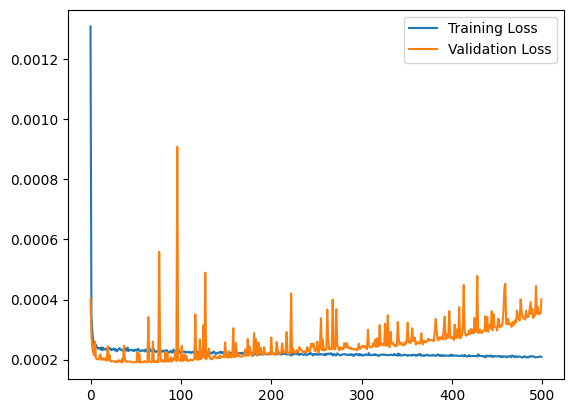

In [19]:
history.history['loss']

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [20]:
predicted = narxffn_model(x)

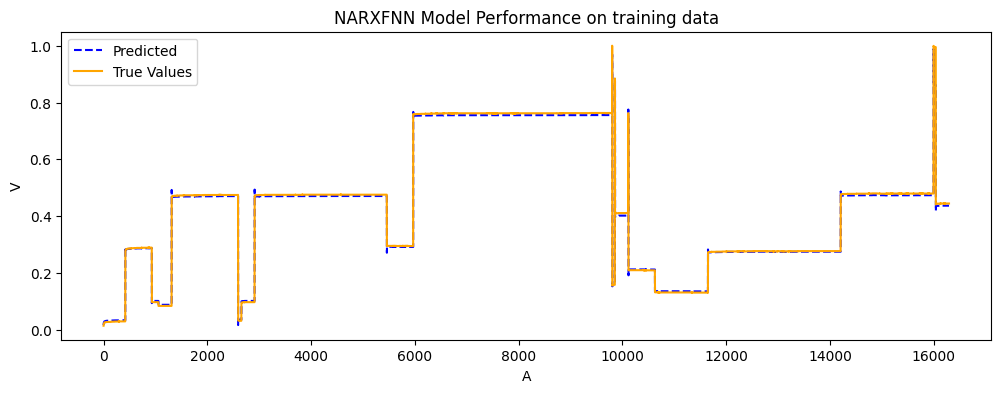

In [21]:
# Create the figure and set the size
plt.figure(figsize=(12, 4))

# Plot the predicted values
plt.plot(predicted, label="Predicted", color="blue", linestyle="--")

# Plot the true values
plt.plot(y, label="True Values", color="orange", linestyle="-")

# Add a title and labels
plt.title("NARXFNN Model Performance on training data")
plt.xlabel("A")
plt.ylabel("V")

# Add a legend to distinguish the lines
plt.legend()

# Show the plot
plt.show()


In [22]:
narxffn_model.evaluate(x,y)

510/510 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7027e-04 - mae: 0.0047


[0.0002566650800872594, 0.005424506030976772]

In [23]:
# Make predictions
y_prednarxffn = narxffn_model.predict(x_valid)

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


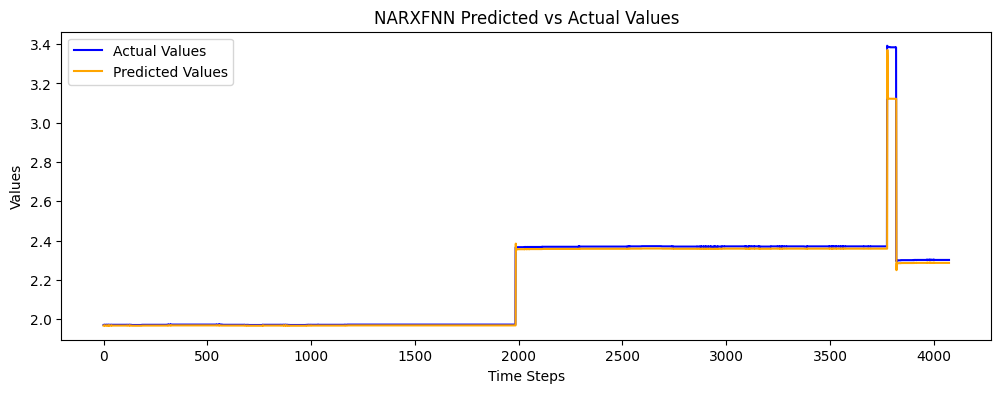

In [24]:
# Reshape y_valid and y_prednarxffn to be 2D arrays
y_valid_reshaped = y_valid.reshape(-1, 1)
y_prednarxffn_reshaped = y_prednarxffn.reshape(-1, 1)

# Rescale back to original values for comparison
y_valid_rescaled = scaler.inverse_transform(
    np.hstack((y_valid_reshaped, np.zeros_like(y_valid_reshaped)))
)
y_prednarxffn_rescaled = scaler.inverse_transform(
    np.hstack((y_prednarxffn_reshaped, np.zeros_like(y_prednarxffn_reshaped)))
)

# Plot predictions vs actuals
plt.figure(figsize=(12, 4))
plt.plot(y_valid_rescaled[:, 0], label="Actual Values", color="blue")
plt.plot(y_prednarxffn_rescaled[:, 0], label="Predicted Values", color="orange")
plt.title("NARXFNN Predicted vs Actual Values")
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()
plt.show()


### 2. Using Long short-term memory (LSTM) Implementation

In [25]:
# def create_narx_sequences(data, target_column, input_lags=3, output_lags=1):
#     """
#     Generates NARX sequences with past target values (AR terms) and exogenous inputs for prediction.

#     Parameters:
#     ----------
#     data : ndarray
#         Time-series data, where each row represents a time step and each column represents a feature.
#     target_column : int
#         Index of the target variable column.
#     input_lags : int
#         Number of past steps for exogenous inputs.
#     output_lags : int
#         Number of past steps for target variable (AR terms).
    
#     Returns:
#     -------
#     np.ndarray, np.ndarray
#         Inputs and target sequences for NARX.
#     """
#     inputs, targets = [], []
#     n_samples = len(data)

#     for i in range(input_lags + output_lags, n_samples):
#         # AR terms: past target values
#         ar_terms = data[i - output_lags:i, target_column]
        
#         # Exogenous terms: past values of other input variables
#         exog_terms = data[i - input_lags:i, :]
        
#         # Combine AR terms and exogenous inputs
#         combined = np.hstack([ar_terms, exog_terms.flatten()])
#         inputs.append(combined)
        
#         # Target: current value of the target variable
#         targets.append(data[i, target_column])
    
#     return np.array(inputs), np.array(targets)


## **NARXNN (Nonlinear Autoregressive with Exogenous Inputs Neural Network with LSTM)**

The **NARXNN** model uses a more sophisticated architecture with an **LSTM (Long Short-Term Memory)** layer to capture sequential dependencies in the time-series data, which is especially useful for time-series forecasting problems.

### **Model Architecture**

```python
narx_model = keras.Sequential([
    layers.LSTM(32, activation='tanh', input_shape=(x_train.shape[1], x_train.shape[2])),
    layers.Dense(16, activation='tanh'),
    layers.Dense(y_train.shape[1], activation='relu')  # Output layer
])
```

- **LSTM Layer (32 units)**:
    - The first layer is an **LSTM** layer with **32 units**. LSTMs are a type of recurrent neural network (RNN) specifically designed to learn long-term dependencies in sequential data.
    - The **activation function** used here is **'tanh'**, which helps capture the nonlinear relationships in the sequential data.
    - The **input shape** is specified as `(x_train.shape[1], x_train.shape[2])`, which represents the number of time steps and the number of features (exogenous inputs) at each time step.

- **Hidden Dense Layer**:
    - A **Dense** layer with **16 units**, using the **'tanh'** activation function. This layer further processes the output of the LSTM layer to capture more complex relationships between the sequence and the target variable.

- **Output Layer**:
    - The final **Dense** layer outputs the predicted values, with the number of units matching the shape of the target variable (`y_train.shape[1]`), and uses the **'relu'** activation function. This activation ensures that the predicted values are non-negative and are appropriate for regression tasks.

### **Model Compilation**

```python
narx_model.compile(
    optimizer=keras.optimizers.Adam(), 
    loss='mse', 
    metrics=['mae']
    )
```

- **Optimizer**: **Adam** is used as the optimizer, known for its efficiency in training neural networks by adjusting the weights through adaptive learning rates.
- **Loss Function**: **Mean Squared Error (MSE)** is the loss function, which penalizes large deviations between the predicted and actual target values.
- **Metrics**: **Mean Absolute Error (MAE)** is used as a metric, providing an average of the absolute errors, which is useful for evaluating the prediction quality.

---

In [26]:
# Reshape x_train and x_valid to add the time dimension
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1])) 
x_valid = x_valid.reshape((x_valid.shape[0], 1, x_valid.shape[1]))

print("Reshaped x_train shape:", x_train.shape)  # (12222, 1, 8)
print("Reshaped x_valid shape:", x_valid.shape)  # (4074, 1, 8)


Reshaped x_train shape: (12222, 1, 8)
Reshaped x_valid shape: (4074, 1, 8)


In [27]:
# Define the NARXNN model
narx_model = keras.Sequential([
    layers.LSTM(32, activation='tanh', input_shape=(1, x_train.shape[2])),  # (timesteps=1, features=8)
    layers.Dense(16, activation='tanh'),
    layers.Dense(1, activation='relu')  # Output layer (single output, since y_train has shape (samples,))
])

# Compile the model
narx_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# # Train the model
# narx_model.fit(
#     x_train, y_train,
#     epochs=20,
#     batch_size=32,
#     validation_data=(x_valid, y_valid)
# )




c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1\env_analysis\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
# Train the model
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

In [29]:
history = narx_model.fit(
    x_train, y_train,
    epochs=500,
    batch_size=32,
    validation_data=(x_valid, y_valid),
    callbacks=[callback],
    verbose=1
)


Epoch 1/500
382/382 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0295 - mae: 0.0893 - val_loss: 3.6252e-04 - val_mae: 0.0120
Epoch 2/500
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.7606e-04 - mae: 0.0087 - val_loss: 2.2787e-04 - val_mae: 0.0053
Epoch 3/500
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.0351e-04 - mae: 0.0039 - val_loss: 2.0029e-04 - val_mae: 0.0033
Epoch 4/500
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.9781e-04 - mae: 0.0034 - val_loss: 1.9998e-04 - val_mae: 0.0046
Epoch 5/500
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6896e-04 - mae: 0.0032 - val_loss: 1.8840e-04 - val_mae: 0.0041
Epoch 6/500
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.5019e-04 - mae: 0.0034 - val_loss: 2.3581e-04 - val_mae: 0.0088
Epoch 7/500
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.3992e-04 - mae: 0.0040 - val_loss: 1.6027e-04 - val_mae: 0.0028
Epoch 8/500
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2238e-04 - mae: 0.0032 - val_loss: 1.6547e-04 - val_

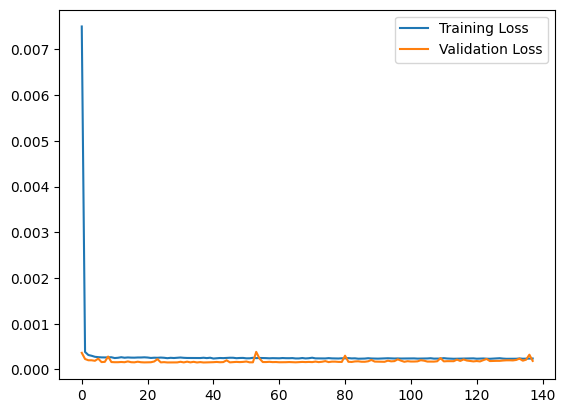

In [30]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [31]:
x = x.reshape((x.shape[0], 1, x.shape[1]))  # Reshape to (samples, timesteps, features)

# Pass the reshaped data to the model
predicted = narx_model(x)


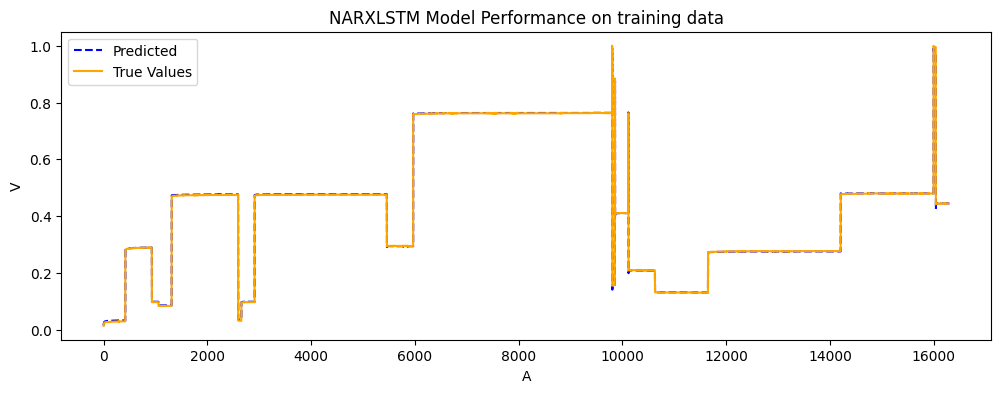

In [32]:
# Create the figure and set the size
plt.figure(figsize=(12, 4))

# Plot the predicted values
plt.plot(predicted, label="Predicted", color="blue", linestyle="--")

# Plot the true values
plt.plot(y, label="True Values", color="orange", linestyle="-")

# Add a title and labels
plt.title("NARXLSTM Model Performance on training data")
plt.xlabel("A")
plt.ylabel("V")

# Add a legend to distinguish the lines
plt.legend()

# Show the plot
plt.show()


In [33]:
narx_model.evaluate(x,y)

510/510 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5810e-04 - mae: 0.0019


[0.00020922919793520123, 0.001607137150131166]

In [34]:
# Make predictions
y_prednarx = narx_model.predict(x_valid)

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


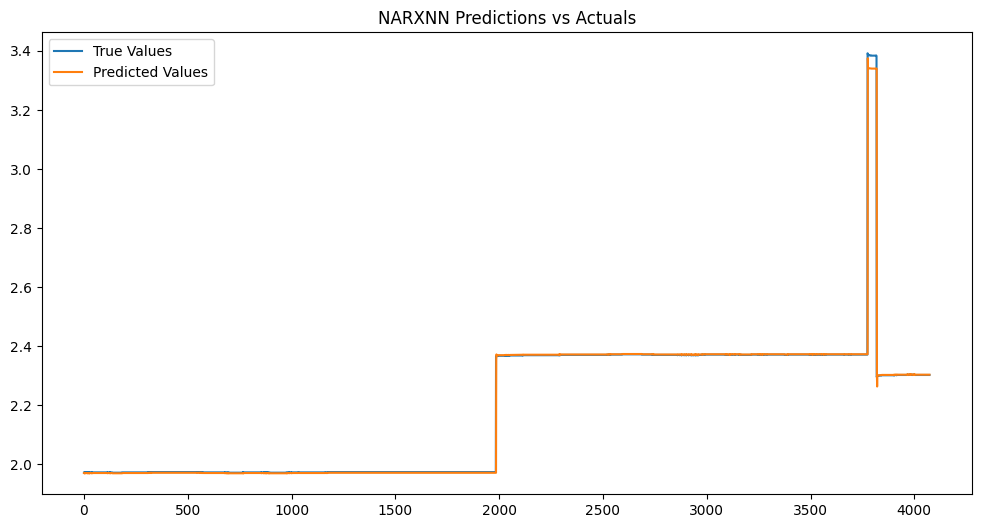

In [35]:
# Rescale back to original values for comparison
y_valid_rescaled = scaler.inverse_transform(
    np.hstack((y_valid.reshape(-1, 1), np.zeros_like(y_valid).reshape(-1, 1)))
)
y_prednarx_rescaled = scaler.inverse_transform(
    np.hstack((y_prednarx.reshape(-1, 1), np.zeros_like(y_prednarx).reshape(-1, 1)))
)

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(y_valid_rescaled[:, 0], label='True Values')
plt.plot(y_prednarx_rescaled[:, 0], label='Predicted Values')
plt.legend()
plt.title('NARXNN Predictions vs Actuals')
plt.show()

### Model Comparison

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# For FNN
mae_fnn = mean_absolute_error(y_valid_rescaled[:, 0], y_prednarxffn_rescaled[:, 0])
mse_fnn = mean_squared_error(y_valid_rescaled[:, 0], y_prednarxffn_rescaled[:, 0])

# For NARXNN
mae_narx = mean_absolute_error(y_valid_rescaled[:, 0], y_prednarx_rescaled[:, 0])
mse_narx = mean_squared_error(y_valid_rescaled[:, 0], y_prednarx_rescaled[:, 0])

# Print results
print(f"FNN - MAE: {mae_fnn}, MSE: {mse_fnn}")
print(f"NARXNN - MAE: {mae_narx}, MSE: {mse_narx}")

# Metrics (MAE, MSE): Which model has the lowest errors?

FNN - MAE: 0.011102570135802873, MSE: 0.001240235509459397
NARXNN - MAE: 0.0028636120104238673, MSE: 0.0005853613299768084



### **Key Differences Between NARXFFN and NARXNN Models**

- **Architecture**: 
    - **NARXFFN** is a simple feedforward neural network with a dense architecture, whereas **NARXNN** uses an LSTM layer to capture sequential dependencies in time-series data.
    - The **NARXNN** model is more complex and better suited for tasks where the target variable is influenced by past time steps (time-series forecasting).

- **Sequence Modeling**: 
    - **NARXNN** is more suitable for handling sequential data, making it better at capturing long-term dependencies and patterns in time-series data. The **LSTM** layer in this model helps address issues like vanishing gradients, which can occur in traditional RNNs.
    - **NARXFFN**, on the other hand, is a simpler model that may be effective for relatively straightforward problems where past values and external inputs are sufficient for prediction.

- **Performance**:
    - **NARXNN** is expected to perform better in time-series forecasting tasks, especially when there are long-term dependencies in the data.
    - **NARXFFN** might be faster to train and simpler to implement but might not capture complex temporal dependencies as effectively as the **NARXNN**.

---